In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r "./drive/MyDrive/Deep_Audio/FastPitch/requirements.txt"

  Cloning https://github.com/NVIDIA/dllogger (to revision v1.0.0) to /tmp/pip-install-6o7p3j8b/dllogger_72e15f7b04c54e1e8fb94bd05ac45aa2
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/dllogger /tmp/pip-install-6o7p3j8b/dllogger_72e15f7b04c54e1e8fb94bd05ac45aa2
  Resolved https://github.com/NVIDIA/dllogger to commit 0540a43971f4a8a16693a9de9de73c1072020769
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.7/211.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.1 MB/s eta 0:00:00
  Created wheel for dllogger: filename=DLLogger-1.0.0-py3-none-any.whl size=5654 sha256=144f5d9bcf2a9b021247288c49a3d5d2b6710a327e17bb0b885cd55ad76500a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-j6k91z50/wheels/84/e6/5f/c9560b8d09a212d0

In [ ]:
import subprocess
import os
import librosa
import shutil
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import torchaudio
import scipy.interpolate
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchaudio.prototype.pipelines import HIFIGAN_VOCODER_V3_LJSPEECH as bundle
import tensorflow as tf
import soundfile as sf
from IPython.display import Audio, display
from ipywidgets import Button, Output
import torch.nn.functional as F
from torchaudio.prototype.pipelines import HiFiGANVocoderBundle

# Inference on 50 examples for evaluation

Prepare input for the inference by converting from .txt to .tsv

In [ ]:
# Path to the .txt file
txt_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test.txt"

# Path to the output .tsv file
output_tsv_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test.tsv"

# Open the output file in write mode
with open(output_tsv_file, "w") as tsv_out:
    # Write the header line
    tsv_out.write("mel\toutput\ttext\n")

    # Open the .txt file and read line by line
    i = 0
    with open(txt_file, "r") as txt_in:
        for line in txt_in:
            output, text = line.strip().split("|")
            filename = f"{i}"
            i += 1
            mel = os.path.splitext(os.path.basename(filename))[0]

            # Write the data in .tsv format
            tsv_out.write(f"{mel}\t{output}\t{text}\n")

print("Transformation completed successfully!")

Transformation completed successfully!


Get first 50 phrases from the test set.


In [ ]:
# Path to the input .tsv file
input_tsv_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test.tsv"

# Path to the output .tsv file
output_tsv_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test_50.tsv"

# Number of lines to keep
num_lines_to_keep = 51

# Open the input file and read the first 50 lines
with open(input_tsv_file, "r") as tsv_in:
    lines = tsv_in.readlines()[:num_lines_to_keep]

# Open the output file and write the selected lines
with open(output_tsv_file, "w") as tsv_out:
    for line in lines:
        tsv_out.write(line)

print("Extraction completed successfully!")


Extraction completed successfully!


Run inference on the 50 phrases extracted.

In [ ]:
def run_shell_script(script_path):
    try:
        command = f'bash "{script_path}"'
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

        if stdout:
            print(f'Standard Output:\n{stdout.decode()}')
        if stderr:
            print(f'Standard Error:\n{stderr.decode()}')
        return_code = process.returncode
        if return_code == 0:
            print(f'Shell script "{script_path}" executed successfully.')
        else:
            print(f'Error: Shell script "{script_path}" returned non-zero exit status {return_code}.')

    except Exception as e:
        print(f'An error occurred: {e}')

In [ ]:
script_path = './drive/MyDrive/Deep_Audio/FastPitch/inference_example_changes_for_colab.sh'
run_shell_script(script_path)

In [ ]:
%cd /content

/content


In [ ]:
def compute_mel_spectrogram(waveform, generator = None):
    if generator is None:
      return
    mel = generator(waveform)
    return mel

Baseline. Reconstract original .wav of the first 50 phrases.

In [ ]:
# Load the HiFiGAN bundle
bundle = HiFiGANVocoderBundle(
    "hifigan_vocoder_v3_ljspeech.pth",
    _vocoder_params={
        "upsample_rates": (8, 8, 4),
        "upsample_kernel_sizes": (16, 16, 8),
        "upsample_initial_channel": 256,
        "resblock_kernel_sizes": (3, 5, 7),
        "resblock_dilation_sizes": ((1, 2), (2, 6), (3, 12)),
        "resblock_type": 2,
        "in_channels": 80,
        "lrelu_slope": 0.1,
    },
    _mel_params={
        "hop_size": 256,
        "n_fft": 1024,
        "win_length": 1024,
        "f_min": 0,
        "f_max": 8000,
    },
    _sample_rate=22050,
)

smaple_rate = 22050
input_dir = "/content/drive/MyDrive/Deep_Audio/Data/Audio_Ground_Truth"
output_dir = "/content/drive/MyDrive/Deep_Audio/Data/Audio_Ground_Truth/Reconstruct"

# Process each WAV file
wavs = os.listdir(input_dir)
for i, wav_name in enumerate(wavs):
    wav_path = os.path.join(input_dir, wav_name)
    waveform, sample_rate = torchaudio.load(wav_path)

    # Compute pad size based on mel parameters
    # The n_fft parameter specifies the number of points to be used in each FFT calculation.
    # So n_fft determines the size of the FFT window
    # hop_size parameter specifies the number of samples between successive frames.
    # The hop_size is like how much you move the window each time.
    # (n_fft - hop_size) / 2
    # By subtracting hop_size from n_fft, we get the amount of overlap between adjacent frames.
    # Since this overlap occurs on both ends of each frame,
    # we divide the result by 2 to get the required padding size on each side of the waveform.
    mel_params = bundle._mel_params
    pad_size = int((mel_params["n_fft"] - mel_params["hop_size"]) / 2)

    # Pad the waveform
    padded_waveform = F.pad(waveform, (pad_size, pad_size), mode='reflect')

    # Compute mel spectrogram
    mel = bundle.get_mel_transform()(padded_waveform)

    # Reconstruct waveform
    vocoder = bundle.get_vocoder()
    reconstructed_waveform = vocoder(mel.squeeze(0))

    output_path = os.path.join(output_dir, wav_name)
    torchaudio.save(output_path, reconstructed_waveform, sample_rate)
    print(f"Processed {i+1}/{len(wavs)}: {wav_name}")

print("Processing complete.")


Playing the reconstructed ground truth files.




In [ ]:
# Directory where the .wav files are located
directory = "/content/drive/MyDrive/Deep_Audio/Data/Audio_Ground_Truth/Reconstruct"

# Get a sorted list of .wav files in the directory
file_list = sorted([f for f in os.listdir(directory) if f.endswith('.wav')])

# Initialize variables
current_index = 0
audio_data = None
sample_rate = None
audio_display = None
button_output = Output()

def load_and_play(index):
    global audio_data, sample_rate, audio_display, current_index

    file_path = os.path.join(directory, file_list[index])
    audio_data, sample_rate = sf.read(file_path)

    if audio_display is not None:
        audio_display.clear_output(wait=True)

    display(Audio(data=audio_data, rate=sample_rate, autoplay=True))

    current_index = index

def on_button_clicked(b):
    global current_index
    current_index += 1

    if current_index < len(file_list):
        load_and_play(current_index)
    else:
        current_index = 0
        load_and_play(current_index)

def display_next_button():
    next_button = Button(description="Next Audio")
    next_button.on_click(on_button_clicked)
    button_output.clear_output()

    with button_output:
        display(next_button)

load_and_play(current_index)
display(button_output)

display_next_button()


Output()

Our model. Load the .npy mel-spectrogram from the inference and run through the Vocoder.

In [ ]:
#Generated by model
prefix = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/audio_ljs_audio_text_test_50_fp32_fastpitch_denoise-0.01"
audio_files = prefix
mels = os.listdir(audio_files)
reconst = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/Reconstruct"
for i in range(len(mels)):
  if not mels[i].endswith('.npy'):
    continue
  print(mels[i][:-4])
  w = os.path.join(prefix, mels[i])
  mel = np.load(w).T
  mel = torch.tensor(mel)
  mel = mel.unsqueeze(0)
  waveform = vocoder(mel)
  torchaudio.save(os.path.join(reconst, mels[i][:-4] + '.wav'), waveform.squeeze(0), sample_rate)

Playing the reconstructed model generated files.


In [ ]:
# Directory where the .wav files are located
directory = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/Reconstruct"

# Get a sorted list of .wav files in the directory
file_list = sorted([f for f in os.listdir(directory) if f.endswith('.wav')])

# Initialize variables
current_index = 0
audio_data = None
sample_rate = None
audio_display = None
button_output = Output()

def load_and_play(index):
    global audio_data, sample_rate, audio_display, current_index

    file_path = os.path.join(directory, file_list[index])
    audio_data, sample_rate = sf.read(file_path)

    if audio_display is not None:
        audio_display.clear_output(wait=True)

    display(Audio(data=audio_data, rate=sample_rate, autoplay=True))

    current_index = index

def on_button_clicked(b):
    global current_index
    current_index += 1

    if current_index < len(file_list):
        load_and_play(current_index)
    else:
        current_index = 0
        load_and_play(current_index)

def display_next_button():
    next_button = Button(description="Next Audio")
    next_button.on_click(on_button_clicked)
    button_output.clear_output()

    with button_output:
        display(next_button)

load_and_play(current_index)
display(button_output)

display_next_button()


Output()

# Pitch Shifting expiriment.

In [ ]:
# Path to the input .tsv file
input_tsv_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test.tsv"

# Path to the output .tsv file
output_tsv_file = "/content/drive/MyDrive/Deep_Audio/Data/ljs_audio_text_test_1.tsv"

# Number of lines to keep
num_lines_to_keep = 2

# Open the input file and read the first 50 lines
with open(input_tsv_file, "r") as tsv_in:
    lines = tsv_in.readlines()[:num_lines_to_keep]

# Open the output file and write the selected lines
with open(output_tsv_file, "w") as tsv_out:
    for line in lines:
        tsv_out.write(line)

print("Extraction completed successfully!")


Extraction completed successfully!


In [ ]:
def plot_spectrogram(mel, save = None):
    # Plot mel spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(mel, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Mel')
    plt.title('Mel Spectrogram')
    if not save is None:
      plt.savefig(save)
    plt.show()


In [ ]:
# Specify the path to the shell script
script_path = './drive/MyDrive/Deep_Audio/FastPitch/inference1.sh'

# Call the function to run the shell script
run_shell_script(script_path)

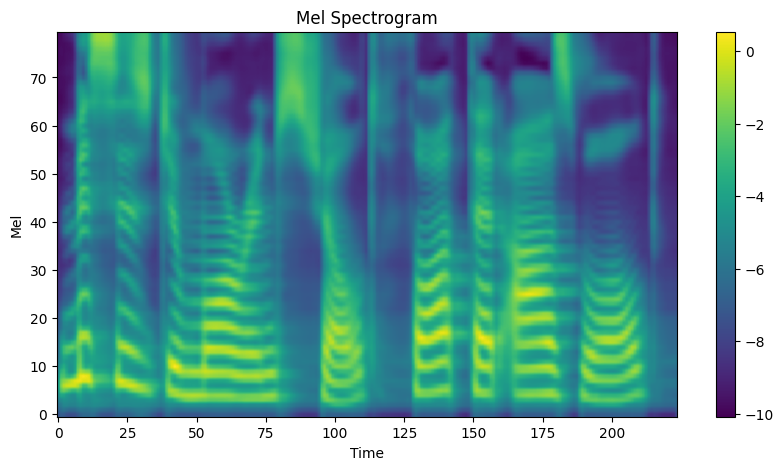

In [ ]:
path = "/content/drive/MyDrive/Deep_Audio/FastPitch/BackUp/LJ045-0096.npy"
mel = np.load(path).T
plot_spectrogram(mel, '/content/drive/MyDrive/Deep_Audio/regular.png')
reconstructed_waveform = vocoder(torch.tensor(mel))
torchaudio.save("regular.wav",reconstructed_waveform,22050)

ARGS+=" --pitch-transform-shift 50"

In [ ]:
bundle = HiFiGANVocoderBundle(
    "hifigan_vocoder_v3_ljspeech.pth",
    _vocoder_params={
        "upsample_rates": (8, 8, 4),
        "upsample_kernel_sizes": (16, 16, 8),
        "upsample_initial_channel": 256,
        "resblock_kernel_sizes": (3, 5, 7),
        "resblock_dilation_sizes": ((1, 2), (2, 6), (3, 12)),
        "resblock_type": 2,
        "in_channels": 80,
        "lrelu_slope": 0.1,
    },
    _mel_params={
        "hop_size": 256,
        "n_fft": 1024,
        "win_length": 1024,
        "f_min": 0,
        "f_max": 8000,
    },
    _sample_rate=22050,
)
vocoder = bundle.get_vocoder()

Downloading: "https://download.pytorch.org/torchaudio/models/hifigan_vocoder_v3_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/hifigan_vocoder_v3_ljspeech.pth
100%|██████████| 5.59M/5.59M [00:01<00:00, 3.39MB/s]


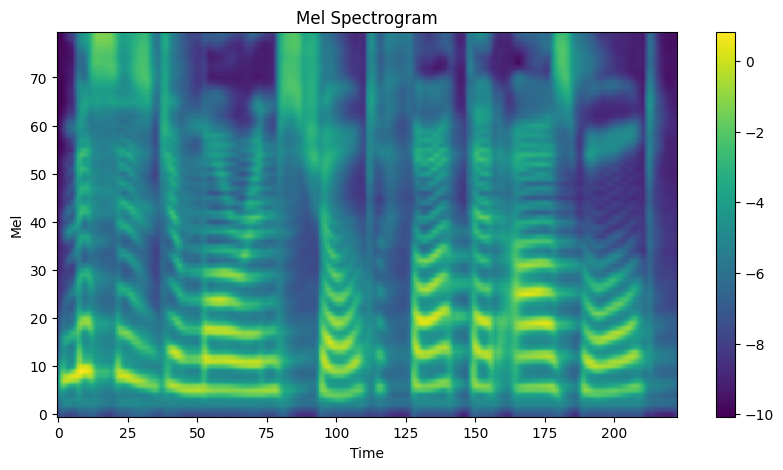

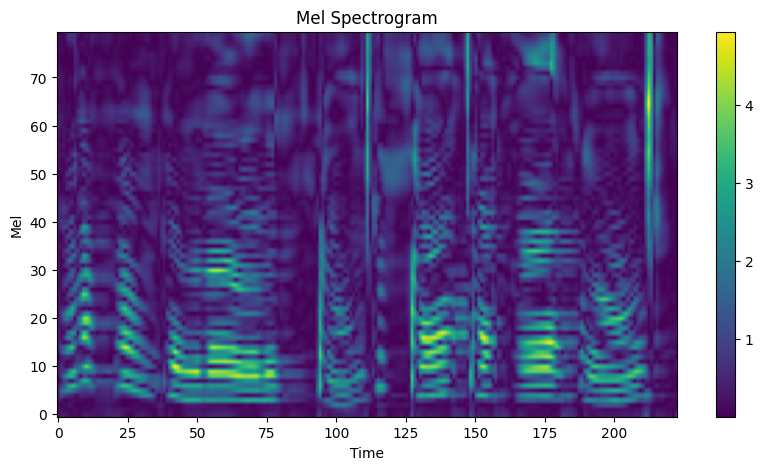

In [ ]:
path = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/audio_ljs_audio_text_test_1_fp32_fastpitch_denoise-0.01/LJ045-0096.npy"
mel_plus = np.load(path).T
# Calculate the absolute difference
mel_abs_diff = np.abs(mel[:, :223] - mel_plus)
plot_spectrogram(mel_plus, '/content/drive/MyDrive/Deep_Audio/shifted_plus.png')
plot_spectrogram(mel_abs_diff, '/content/drive/MyDrive/Deep_Audio/diff_plus.png')
# push to the vocoder and save
reconstructed_waveform = vocoder(torch.tensor(mel_plus))
torchaudio.save("plus.wav",reconstructed_waveform,22050)

Play the shifted pitch wave

ARGS+=" --pitch-transform-shift -50"

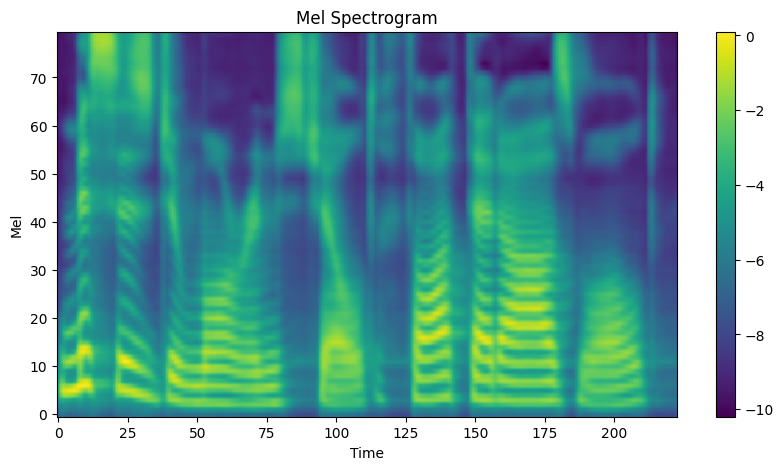

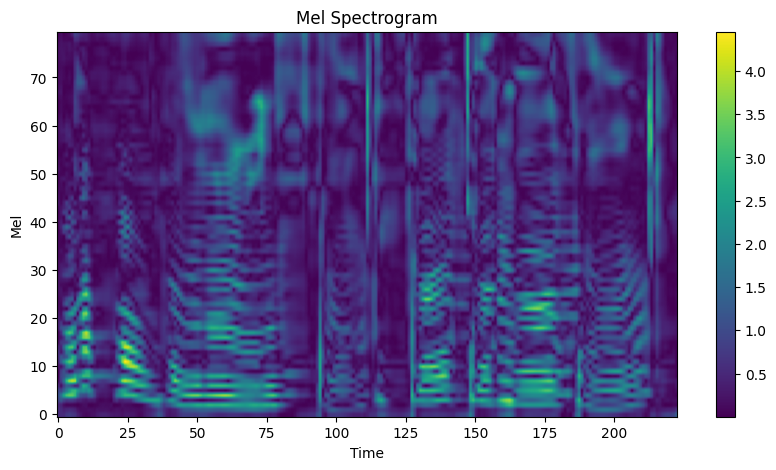

In [ ]:
# Now run inference1 again AFTER changing --pitch-transform-shift to be 50 in inference 1
path = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/audio_ljs_audio_text_test_1_fp32_fastpitch_denoise-0.01/LJ045-0096.npy"
mel_minus = np.load(path).T
plot_spectrogram(mel_minus, '/content/drive/MyDrive/Deep_Audio/shifted_minus.png')
mel_abs_diff = np.abs(mel[:, :223] - mel_minus)
plot_spectrogram(mel_abs_diff, '/content/drive/MyDrive/Deep_Audio/diff_minus.png')
reconstructed_waveform = vocoder(torch.tensor(mel_minus))
torchaudio.save("minus.wav",reconstructed_waveform,22050)

In [ ]:
def play_wav(file_path):
    try:
        audio_data, sample_rate = sf.read(file_path)
        display(Audio(data=audio_data, rate=sample_rate, autoplay=True))
    except Exception as e:
        print("An error occurred:", e)

play_wav('./regular.wav')

In [ ]:
play_wav('./plus.wav')

In [ ]:
play_wav('./minus.wav')

In [ ]:
import subprocess
import os
import librosa
import shutil
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import torchaudio
import scipy.interpolate
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchaudio.prototype.pipelines import HIFIGAN_VOCODER_V3_LJSPEECH as bundle
import tensorflow as tf

def run_shell_script(script_path):
    try:
        # Enclose the script path in quotes to handle spaces
        command = f'bash "{script_path}"'
        # Run the command using subprocess and capture output
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        # Decode and print the standard output
        if stdout:
            print(f'Standard Output:\n{stdout.decode()}')
        # Decode and print the standard error
        if stderr:
            print(f'Standard Error:\n{stderr.decode()}')
        # Check the return code
        return_code = process.returncode
        if return_code == 0:
            print(f'Shell script "{script_path}" executed successfully.')
        else:
            print(f'Error: Shell script "{script_path}" returned non-zero exit status {return_code}.')
    except Exception as e:
        print(f'An error occurred: {e}')

# Specify the path to the shell script
script_path = './drive/MyDrive/Deep_Audio/For_480/inference_example_changes_for_colab.sh'
# Call the function to run the shell script
run_shell_script(script_path)

# Load the audio file
generator = bundle.get_mel_transform()
vocoder = bundle.get_vocoder()
sample_rate = 44100

def compute_mel_spectrogram(waveform, generator=None):
    if generator is None:
        return
    mel = generator(waveform)
    return mel

def plot_spectrogram(mel):
    # Plot mel spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(mel, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Mel')
    plt.title('Mel Spectrogram')
    plt.show()

audio_files = "/content/drive/MyDrive/Deep_Audio/FastPitch"
mels = os.listdir(audio_files)
prefix = "/content/drive/MyDrive/Deep_Audio/FastPitch"
reconst = "/content/drive/MyDrive/Deep_Audio/FastPitch/output/Reconstruct"

for i in range(len(mels)):
    if not mels[i].endswith('.npy'):
        continue
    print(mels[i][:-4])
    w = os.path.join(prefix, mels[i])
    mel = np.load(w).T
    mel = torch.tensor(mel)
    mel = mel.unsqueeze(0)
    waveform = vocoder(mel)
    torchaudio.save(os.path.join(reconst, mels[i][:-4] + '.wav'), waveform.squeeze(0), sample_rate//2)